In [1]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import ast
import pickle 

In [57]:
animes_data_path = "preprocessed_animes.csv"
profiles_data_path = "preprocessed_profiles.csv"
reviews_data_path = "preprocessed_reviews.csv"
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

<ipython-input-57-7df933736d05>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [3]:
np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique().tolist()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
movie_new2old_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    movie_new2old_id_dict[j] = i
    j += 1

In [4]:
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()

In [5]:
def MF_PreTrained_Embeddings(latent_factors):
  P = np.random.rand(num_user, latent_factors)
  Q = np.random.rand(latent_factors, num_items)

  a = 0.01
  b = 0.1
  train_loss = []
  test_loss = []
  nonzero_indices_train = np.nonzero(train_mat)
  nonzero_indices_test = np.nonzero(test_mat)

  num_epochs = 5
  for epoch in range(num_epochs):
      for i in range(num_user):
          for j in range(num_items):
              if train_mat[i, j] > 0:
                  diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                  P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                  Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

      predicted_matrix = np.dot(P, Q)
      
      rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
      rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

      train_loss.append(rmse_train)
      test_loss.append(rmse_test)

      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(rmse_test))
    
  return P, Q

In [133]:
latent_factors_for_MF = 30
P1, Q1 = MF_PreTrained_Embeddings(latent_factors_for_MF)

Epoch 1 of 5: RMSE Train Loss: 1.8021, RMSE Test Loss: 2.0576
Epoch 2 of 5: RMSE Train Loss: 1.5839, RMSE Test Loss: 1.9752
Epoch 3 of 5: RMSE Train Loss: 1.4589, RMSE Test Loss: 1.9473
Epoch 4 of 5: RMSE Train Loss: 1.3677, RMSE Test Loss: 1.9364
Epoch 5 of 5: RMSE Train Loss: 1.2928, RMSE Test Loss: 1.9333


In [58]:
animes['popularity']

0        141
1         28
2         98
3          4
4        502
        ... 
6782    2382
6783    1648
6784    1547
6785    2154
6786     883
Name: popularity, Length: 6787, dtype: int64

In [143]:
import math 

popularity_list = [math.log(popularity, 2) + 0.01 for popularity in animes['popularity'].tolist()]
score = animes['score'].tolist()

In [71]:
indices_train = np.argwhere(train_mat > 0)
train_df = {'user_id': [], 'item_id': [], 'rating': [], 'item_features': []}
for index in indices_train:
  train_df['user_id'].append(index[0])
  train_df['item_id'].append(index[1])
  train_df['rating'].append(train_mat[index[0], index[1]])
  train_df['item_features'].append([1 / popularity_list[index[1]], score[index[1]]])

indices_test = np.argwhere(test_mat > 0)
test_df = {'user_id': [], 'item_id': [], 'rating': [], 'item_features': []}
for index in indices_test:
  test_df['user_id'].append(index[0])
  test_df['item_id'].append(index[1])
  test_df['rating'].append(test_mat[index[0], index[1]])
  test_df['item_features'].append([1 / popularity_list[index[1]], score[index[1]]])

In [72]:
train_df = pd.DataFrame(train_df)
print(train_df.head())

test_df = pd.DataFrame(test_df)
print(test_df.head())

   user_id  item_id  rating                item_features
0        0        0     8.0   [0.1398689163431889, 8.82]
1        0       69     6.0  [0.08483443424437374, 7.88]
2        0      106     7.0  [0.10409954679068978, 7.91]
3        0      119     8.0  [0.08827700898407186, 7.92]
4        0      167     7.0  [0.08667039156668174, 7.96]
   user_id  item_id  rating                item_features
0        0        1     8.0   [0.2075827951603111, 8.83]
1        0       94     6.0   [0.08618517078860513, 7.9]
2        0      147     9.0  [0.08984010923514645, 7.94]
3        0      196     7.0  [0.08448408766066523, 7.99]
4        0      237     7.0   [0.1262165805380088, 8.02]


In [73]:
from torch.utils.data import DataLoader, TensorDataset
train_user_ids = torch.LongTensor(train_df['user_id'].values)
train_item_ids = torch.LongTensor(train_df['item_id'].values)
train_ratings = torch.FloatTensor(train_df['rating'].values)
train_item_features = torch.FloatTensor(train_df['item_features'])

train_dataset = TensorDataset(train_user_ids, train_item_ids, train_ratings, train_item_features)
batch_size = 256

# Create a DataLoader that generates batches of data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_user_ids = torch.LongTensor(test_df['user_id'].values)
test_item_ids = torch.LongTensor(test_df['item_id'].values)
test_ratings = torch.FloatTensor(test_df['rating'].values)
test_item_features = torch.FloatTensor(test_df['item_features'])

test_dataset = TensorDataset(test_user_ids, test_item_ids, test_ratings, test_item_features)

# Create a DataLoader that generates batches of data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim, item_features_dim, pretrained_user_embs, pretrained_item_embs):
        super(NCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.item_features_dim = item_features_dim
        
        # User and item embeddings
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 2 + item_features_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        
        if pretrained_user_embs is not None:
            self.user_embed.weight.data.copy_(torch.from_numpy(pretrained_user_embs))
        if pretrained_item_embs is not None:
            self.item_embed.weight.data.copy_(torch.from_numpy(pretrained_item_embs)) 

        
    def forward(self, user, item, item_features):
        # Embedding lookup
        user_embed = self.user_embed(user)
        item_embed = self.item_embed(item)
        
        # Concatenate the user and item embeddings
        x = None
        if self.item_features_dim == 0:
          x = torch.cat([user_embed, item_embed], dim=1)
        else:
          x = torch.cat([user_embed, item_embed, item_features], dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Apply sigmoid function to output
        x = torch.sigmoid(x) * 10
        
        return x.squeeze()


In [122]:
from pandas._libs.tslibs.offsets import QuarterOffset
# Define the model, loss function, and optimizer
import matplotlib.pyplot as plt

def train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, P, Q):
  embedding_dim = latent_factors
  
  model = NCF(num_user, num_items, embedding_dim, hidden_dim, item_features_dim, P, Q)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # Training loop
  train_loss = []
  test_loss = []
  for epoch in range(num_epochs):
      model.train()
      running_train_loss = []
      for batch in train_dataloader:
          # Unpack the batch
          user, item, rating, item_features = batch
          
          # Forward pass
          rating_pred = model(user, item, item_features)
          loss = loss_fn(rating_pred, rating)
          running_train_loss.append(np.sqrt(loss.item()))
          
          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
      model.eval()
      running_test_loss = []

      with torch.no_grad():
        for batch in test_dataloader:
          user, item, rating, item_features = batch
          rating_pred = model(user, item, item_features)
          loss = loss_fn(rating_pred, rating)
          running_test_loss.append(np.sqrt(loss.item()))
      
      print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
      print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
      print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

      train_loss.append(np.mean(running_train_loss))
      test_loss.append(np.mean(running_test_loss))

  x = [i + 1 for i in range(num_epochs)]
  plt.plot(x, train_loss, label='train_loss')
  plt.plot(x, test_loss, label='test_loss')
  leg = plt.legend(loc='upper center')
  plt.xticks([i + 1 for i in range(0, num_epochs, 3)]) 
  plt.show()

### Baseline NCF

Epoch 1 of 10: RMSE Train Loss: 2.2095, RMSE Test Loss: 2.0940
Epoch 2 of 10: RMSE Train Loss: 1.9499, RMSE Test Loss: 1.9741
Epoch 3 of 10: RMSE Train Loss: 1.7540, RMSE Test Loss: 1.9359
Epoch 4 of 10: RMSE Train Loss: 1.6155, RMSE Test Loss: 1.9403
Epoch 5 of 10: RMSE Train Loss: 1.5184, RMSE Test Loss: 1.9524
Epoch 6 of 10: RMSE Train Loss: 1.4438, RMSE Test Loss: 1.9672
Epoch 7 of 10: RMSE Train Loss: 1.3865, RMSE Test Loss: 1.9879
Epoch 8 of 10: RMSE Train Loss: 1.3385, RMSE Test Loss: 2.0095
Epoch 9 of 10: RMSE Train Loss: 1.2956, RMSE Test Loss: 2.0237
Epoch 10 of 10: RMSE Train Loss: 1.2589, RMSE Test Loss: 2.0389


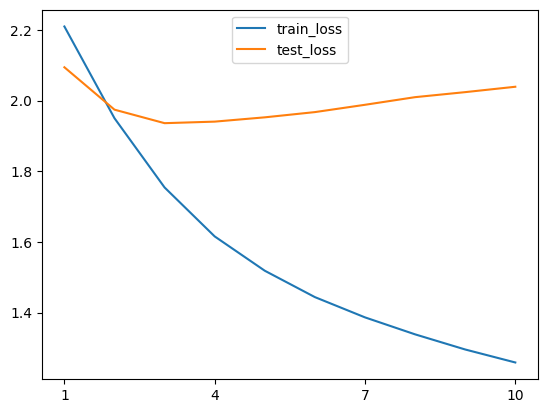

In [130]:
item_features_dim = 0
lr = 0.005
num_epochs = 10
hidden_dim = 20
latent_factors = 30

train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, None, None)

### NCF + MF Hybrid (Uses pretrained embeddings of MF)

Epoch 1 of 15: RMSE Train Loss: 2.1234, RMSE Test Loss: 2.0746
Epoch 2 of 15: RMSE Train Loss: 1.8684, RMSE Test Loss: 1.9052
Epoch 3 of 15: RMSE Train Loss: 1.6852, RMSE Test Loss: 1.8624
Epoch 4 of 15: RMSE Train Loss: 1.6040, RMSE Test Loss: 1.8578
Epoch 5 of 15: RMSE Train Loss: 1.5585, RMSE Test Loss: 1.8612
Epoch 6 of 15: RMSE Train Loss: 1.5280, RMSE Test Loss: 1.8678
Epoch 7 of 15: RMSE Train Loss: 1.5058, RMSE Test Loss: 1.8761
Epoch 8 of 15: RMSE Train Loss: 1.4863, RMSE Test Loss: 1.9024
Epoch 9 of 15: RMSE Train Loss: 1.4724, RMSE Test Loss: 1.8872
Epoch 10 of 15: RMSE Train Loss: 1.4561, RMSE Test Loss: 1.8988
Epoch 11 of 15: RMSE Train Loss: 1.4445, RMSE Test Loss: 1.9067
Epoch 12 of 15: RMSE Train Loss: 1.4330, RMSE Test Loss: 1.9125
Epoch 13 of 15: RMSE Train Loss: 1.4215, RMSE Test Loss: 1.9199
Epoch 14 of 15: RMSE Train Loss: 1.4097, RMSE Test Loss: 1.9279
Epoch 15 of 15: RMSE Train Loss: 1.3997, RMSE Test Loss: 1.9317


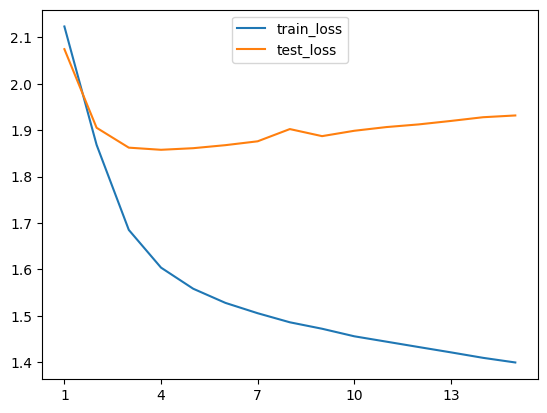

In [134]:
item_features_dim = 0
lr=0.001
num_epochs=15
latent_factors = 30

train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, P1, Q1.T)

### NCF + MF + Item Features

Epoch 1 of 15: RMSE Train Loss: 2.2277, RMSE Test Loss: 2.1483
Epoch 2 of 15: RMSE Train Loss: 1.9888, RMSE Test Loss: 1.9854
Epoch 3 of 15: RMSE Train Loss: 1.7570, RMSE Test Loss: 1.9204
Epoch 4 of 15: RMSE Train Loss: 1.6586, RMSE Test Loss: 1.9016
Epoch 5 of 15: RMSE Train Loss: 1.6044, RMSE Test Loss: 1.8957
Epoch 6 of 15: RMSE Train Loss: 1.5687, RMSE Test Loss: 1.8873
Epoch 7 of 15: RMSE Train Loss: 1.5404, RMSE Test Loss: 1.8910
Epoch 8 of 15: RMSE Train Loss: 1.5202, RMSE Test Loss: 1.8907
Epoch 9 of 15: RMSE Train Loss: 1.5022, RMSE Test Loss: 1.8986
Epoch 10 of 15: RMSE Train Loss: 1.4865, RMSE Test Loss: 1.9012
Epoch 11 of 15: RMSE Train Loss: 1.4729, RMSE Test Loss: 1.9038
Epoch 12 of 15: RMSE Train Loss: 1.4602, RMSE Test Loss: 1.9046
Epoch 13 of 15: RMSE Train Loss: 1.4468, RMSE Test Loss: 1.9152
Epoch 14 of 15: RMSE Train Loss: 1.4346, RMSE Test Loss: 1.9213
Epoch 15 of 15: RMSE Train Loss: 1.4230, RMSE Test Loss: 1.9218


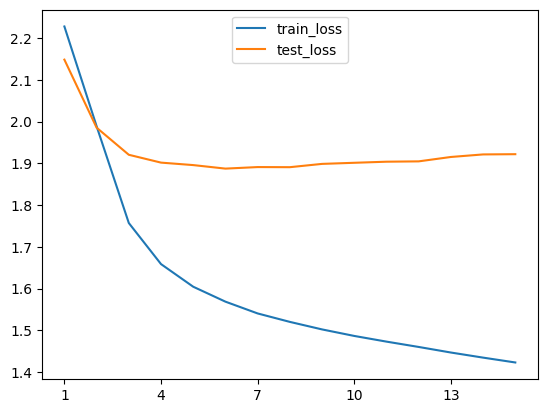

In [142]:
item_features_dim = 2
lr=0.0005
num_epochs = 15
latent_factors = 30
train_NCF(item_features_dim, lr, num_epochs, hidden_dim, latent_factors, P1, Q1.T)